# Scraping the met office forecast page for predictor variables for dataframe. #

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from tqdm import tqdm
from random import randint
from time import sleep
import time
import random
import datetime
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<ipython-input-2-e765ab03325e>:69: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  tablest1[i-1]['winddir'], tablest1[i-1]['wind'] = tablest1[i-1]['Wind direction and speed (miles per hour)'].str.split(' ').str
<ipython-input-2-e765ab03325e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Table2['Weather symbol'] = syms[(len(tables[0].T)-1):]
<ipython-input-2-e765ab03325e>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Table2['cld_ttl_amt_id'] = 0
<ipython-inp

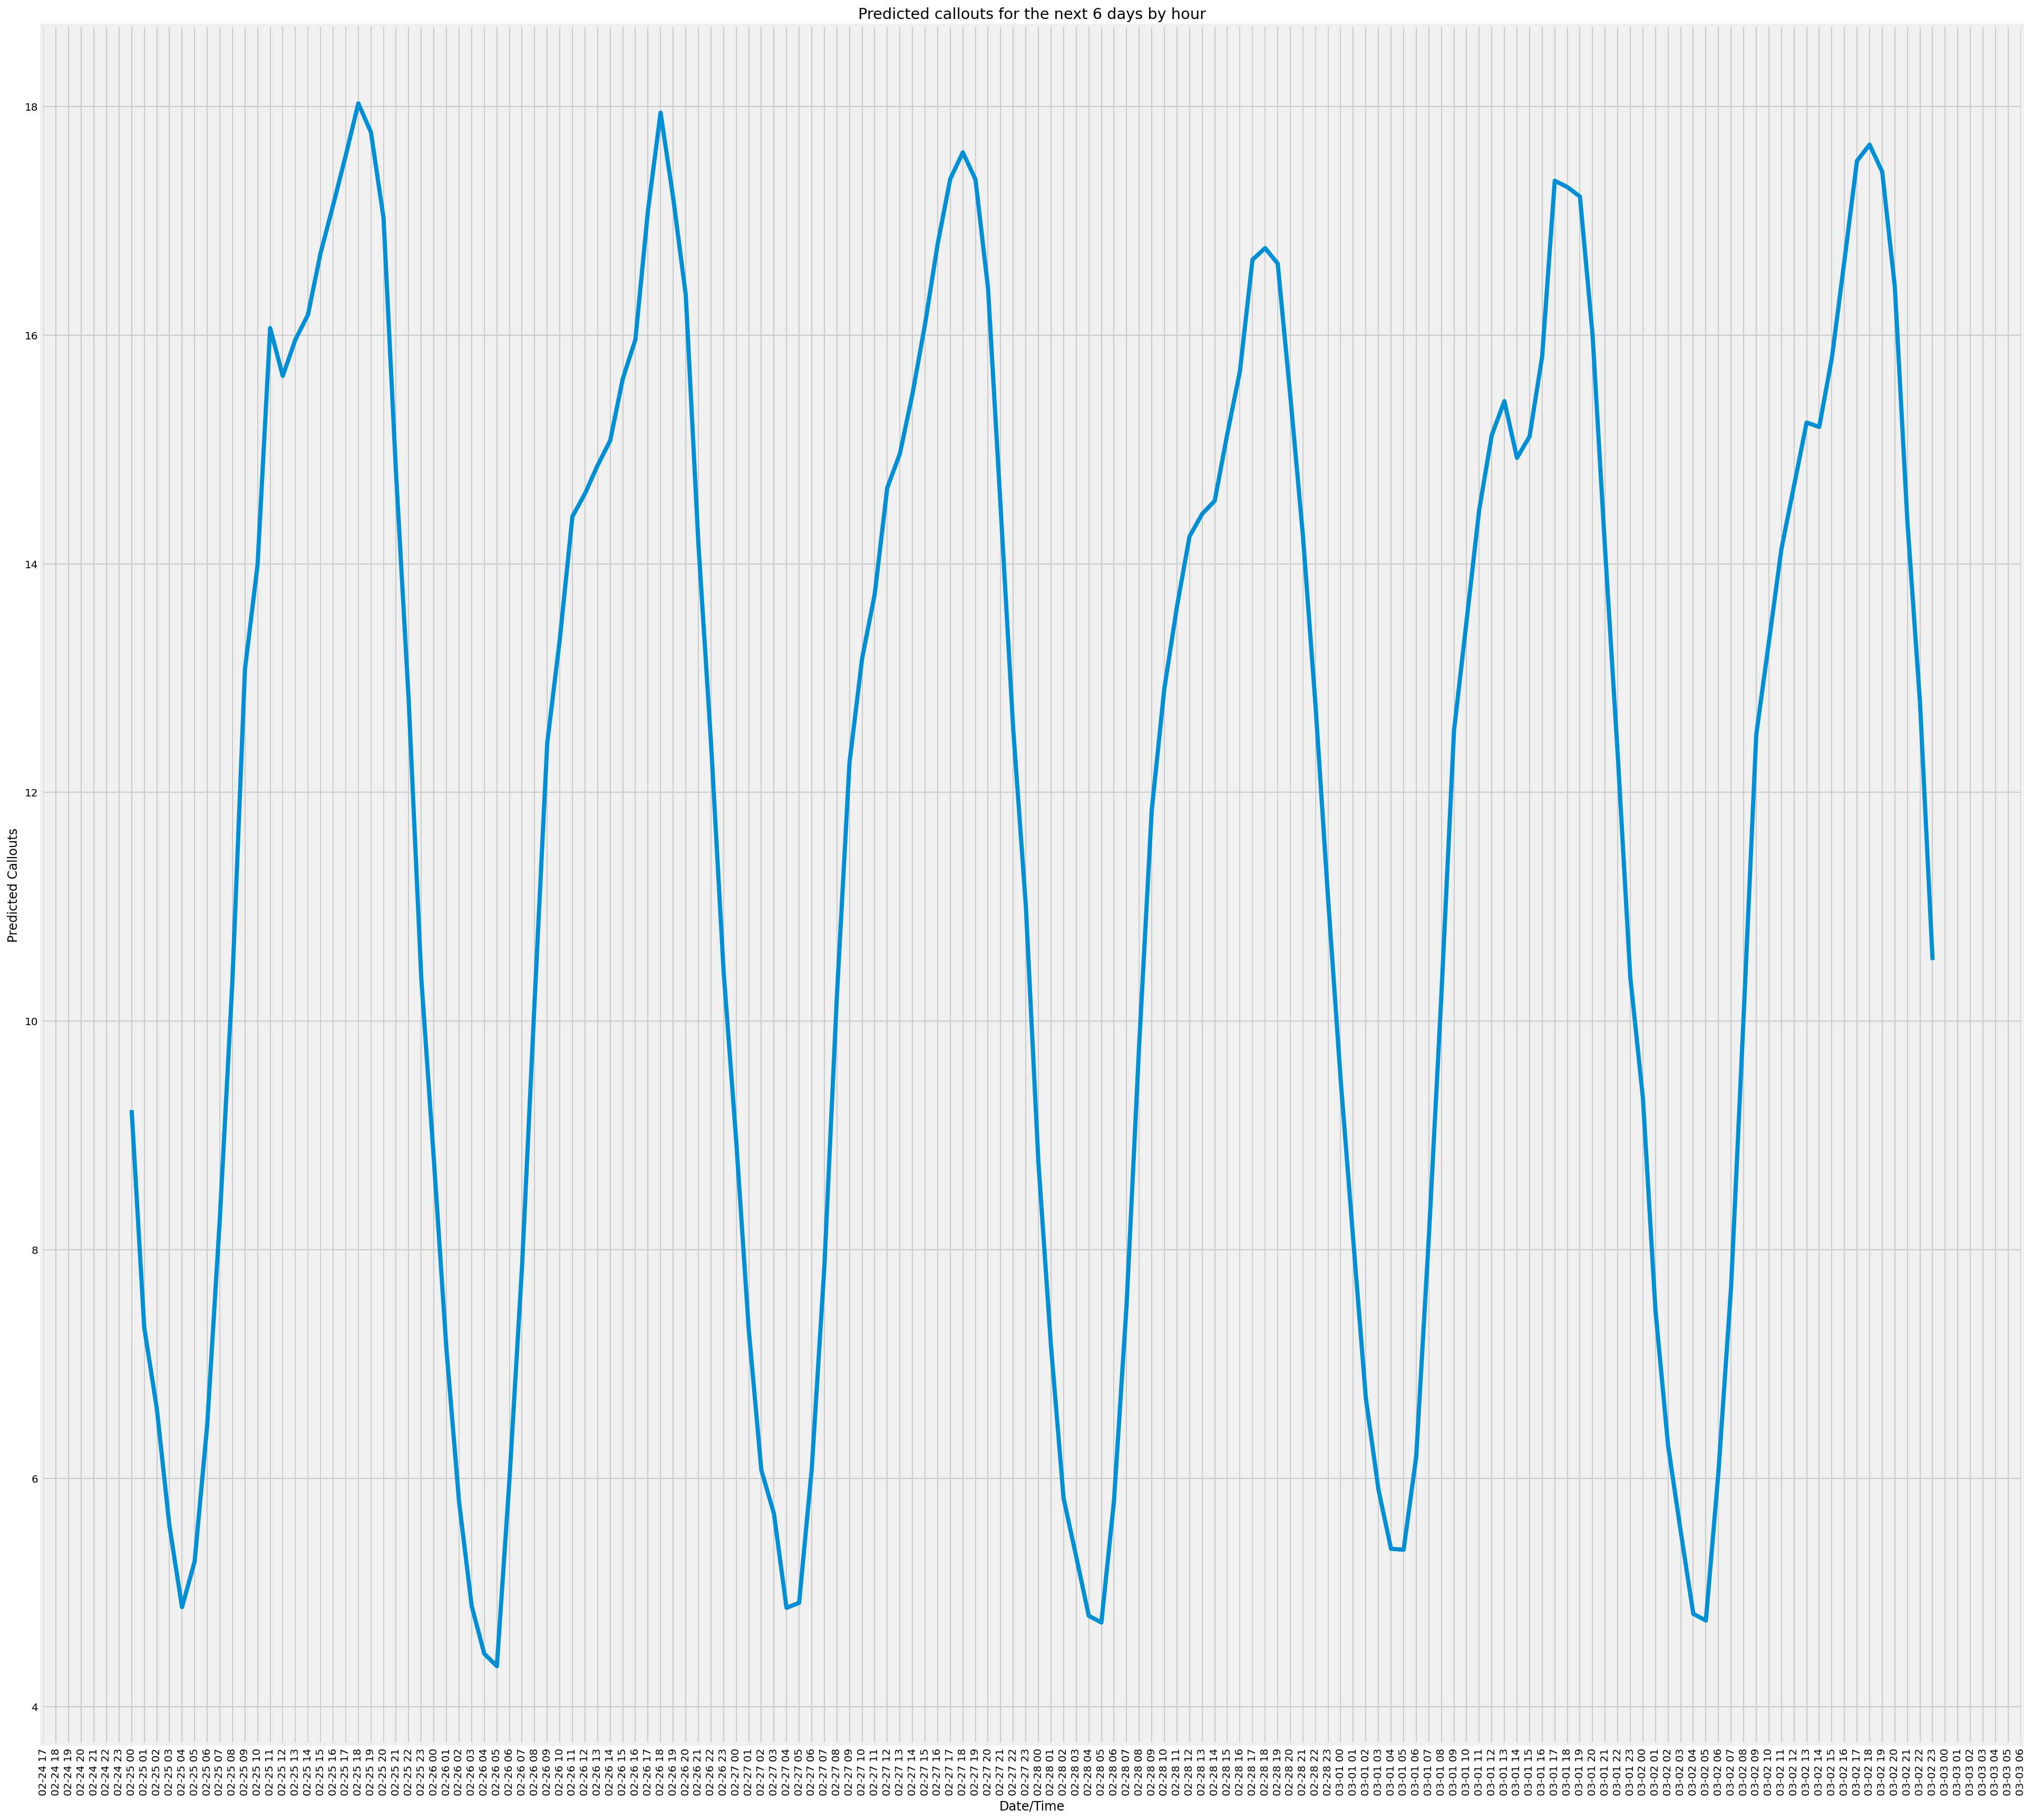

In [2]:
# Imprting the met office forecast page for London (rest of today and 6 days after)
url = "https://www.metoffice.gov.uk/weather/forecast/gcpvj0v07#?date=2021-02-03"
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

days=[]
dates = []
suntimes = []
syms=[]

for d in soup.find_all('li', attrs = {'class':'forecast-tab'}):
    dates.append(d['data-tab-id'])
    days.append(d['data-day'])
    suntimes.append(d.find('div', attrs = {'class':'off-screen'}).text)
    
for f in soup.find_all('div', attrs = {'id':'forecastContent'}):
    for sym in f.find_all('tr', attrs = {'class':'step-symbol'}):
        for im in sym.find_all('img'):
            syms.append(im['title'])
            
# Creating the tables with each day's variables
tables = pd.read_html(r.text) 

#air pressure - actual from met office heathrow.
urlp = "https://www.metoffice.gov.uk/weather/observations/gcpsvg3nc"
rp = requests.get(urlp)
tablesp = pd.read_html(rp.text)
airpress = tablesp[1].iloc[13,-1]

#create dataframes:

index = range(6*24)
df_ = pd.DataFrame(index=index)#, columns = tables[0].T.iloc[0,:]
df_ = df_.fillna(0) # with 0s rather than NaNs

Date = []
for i in range(6):
    for j in range(24):
        Date.append(dates[i+1])

time = []
for i in range(6):
    for j in range(24):
        time.append(j)

df_['Date'] = Date
df_['time'] = time

# Creating timeseries index
df_['ob_time'] = pd.to_datetime(df_['Date']+'-'+df_['time'].astype(str),format='%Y-%m-%d-%H')
df_.set_index('ob_time', inplace=True, drop=True)


# extracting sunrise and sunset data and populating dataframes
import re
patternrise = re.compile(r'Sun......\d\d')
patternset = re.compile(r'Sun.....\d\d')
tablest = [1,2,3,4,5,6]
tablest1 = [1,2,3,4,5,6]
for i in range(1,7):
    tablest[i-1] = tables[i].T
    tablest[i-1].columns = list(tablest[i-1].iloc[0,:])
    tablest1[i-1] = tablest[i-1].drop('Time', axis = 0)
    tablest1[i-1]['Time'] =  tablest1[i-1].index
    tablest1[i-1]['Date'] = dates[i]
    tablest1[i-1]['ob_time'] = pd.to_datetime(tablest1[i-1]['Date']+'-'+tablest1[i-1]['Time'].astype(str),format='%Y-%m-%d-%H:%M')
    tablest1[i-1].set_index('ob_time', inplace=True, drop=True)
    tablest1[i-1]['air_temperature'] = tablest1[i-1]['Temperature (°C)'].str.replace('°','').astype(float)
    tablest1[i-1]['Chance of precipitation'] = tablest1[i-1]['Chance of precipitation'].str.replace(r'[≥<%]','').astype(float)
    tablest1[i-1]['prcp_amt'] = tablest1[i-1]['Chance of precipitation']*0.02-0.1
    tablest1[i-1]['rltv_hum'] = tablest1[i-1]['Humidity'].str.replace(r'[<%]','').astype(float)
    tablest1[i-1]['winddir'], tablest1[i-1]['wind'] = tablest1[i-1]['Wind direction and speed (miles per hour)'].str.split(' ').str
    tablest1[i-1]['wind_speed'] = tablest1[i-1]['wind'].astype(float)*0.868976
    tablest1[i-1]['wind_direction'] = tablest1[i-1]['winddir'].replace({'N':0,'NNE': 22.5, 'NE':45,'ENE':67.5, 'E':90, 'ESE':112.5,
                                                                       'SE':135,'SSE':157.5,'S':180,'SSW':202.5,'SW':225,
                                                                       'WSW': 247.5,'W':270,'WNW':292.5, 'NW':315,'NNW':337.5})
    tablest1[i-1]['max_gust_speed'] = tablest1[i-1]['Wind gust (miles per hour)'].astype(float)*0.868976
    tablest1[i-1]['visibility'] = tablest1[i-1]['Visibility'].replace({'E':5000, 'VG':5000, 'G':4000, 'M':2000,'P':1000,'VP':500})
    tablest1[i-1]['sunrise'] = int(re.findall(patternrise, suntimes[i])[0].replace('Sunrise: ',''))
    tablest1[i-1]['sunset'] = int(re.findall(patternset, suntimes[i])[0].replace('Sunset: ',''))
    tablest1[i-1]['islight']=0
    #for j in range(len(tablest1[i-1]['sunrise'])):        
        #tablest1[i-1]['islight'][j]=((tablest1[i-1]['sunrise'][j] <= tablest1[i-1].index[j].hour) and (tablest1[i-1].index[j].hour < tablest1[i-1]['sunset'][j]))*1
    
    tablest1[i-1]['stn_pres'] = airpress
    
Table1 = pd.concat([tablest1[0],tablest1[1],tablest1[2],tablest1[3],tablest1[4],tablest1[5]])
Table2 = Table1.iloc[:,[0,17,18,19,20,21,24,25,26,27,28,29,30,31]]
Table2['Weather symbol'] = syms[(len(tables[0].T)-1):]
Table2['cld_ttl_amt_id'] = 0
Table2['weekend'] = 0
Table2['holiday'] = 0
Table2['wmo_hr_sun_dur'] = 0.0

# Translating weather symbols
for k in range(len(Table2['Weather symbol'])):
    
    if Table2['Weather symbol'][k] == 'Sunny day':
        Table2['wmo_hr_sun_dur'][k] = 1
        
    elif Table2['Weather symbol'][k] == 'Partly cloudy (night)':
        Table2['cld_ttl_amt_id'][k] = 2
        
    elif Table2['Weather symbol'][k] == 'Sunny intervals':
        Table2['cld_ttl_amt_id'][k] = 2
        Table2['wmo_hr_sun_dur'][k] = 0.5
        
    elif Table2['Weather symbol'][k] == 'Cloudy':
        Table2['cld_ttl_amt_id'][k] = 6
    else: 
        Table2['cld_ttl_amt_id'][k] = 8

# Creating holiday and islight markers
import holidays
hols = []
for ptr in holidays.England(years = [2021]).items(): 
    hols.append(ptr[0]) 
for hol in hols:
    for i in range(len(Table2.index)):
        if Table2.index.date[i] == hol:
            Table2['holiday'][i] = 1 
        if ((Table2.index.weekday[i] == 5) or (Table2.index.weekday[i] == 6)):
            Table2['weekend'][i] = 1        
        if ((Table2['sunrise'][i] <= Table2.index.hour[i]) and (Table2.index.hour[i] < Table2['sunset'][i])) == True:
            Table2['islight'][i] = 1
        
Table3  = df_.merge(Table2, on = 'ob_time',how = 'outer')
Table3.fillna(method='pad',inplace=True)

# Creating lockdown marker
series = pd.Series(['2020/03/23', '2020/06/15', '2020/11/05', '2020/12/02','2021/01/05'])
lockdates = pd.to_datetime(series)
Table3['lockdown'] = 0
for i in Table3.index:
    if (((i >= lockdates[0])&(i < lockdates[1]))|((i >= lockdates[2]) \
                                    & (i < lockdates[3]))|((i >= lockdates[4]) )) == True:
        Table3['lockdown'][i] = 1

# Categorising Wind direction        
Table3['wind_dirc'] = [1 if x<20 else 2 if x<40 else 3 if x<60 else 4 if x <80 else 5 if x<100 else 6 if x<120 \
                          else 7 if x< 140 else 8 if x< 160 else 9 if x< 180 else 10 if x<200 else 11 if x<220 \
                           else 12 if x< 240 else 13 if x < 260 else 14 if x< 280 else 15 if x < 300 \
                          else 16 if x< 320 else 17 if x < 340 else 18 for x in Table3['wind_direction']]

Table3['HourOfCall'] = Table3['time']
Table3dum = pd.get_dummies(Table3, columns=['wind_dirc', 'HourOfCall'])

for w in ['wind_dirc_1', 'wind_dirc_2', 'wind_dirc_3', 'wind_dirc_4', 'wind_dirc_5', 'wind_dirc_6', 'wind_dirc_7', \
 'wind_dirc_8', 'wind_dirc_9', 'wind_dirc_10', 'wind_dirc_11', 'wind_dirc_12', 'wind_dirc_13', 'wind_dirc_14', \
 'wind_dirc_15', 'wind_dirc_16', 'wind_dirc_17', 'wind_dirc_18',]:
    if w not in list(Table3dum.columns):
        Table3dum[w] = 0

# Getting prioryear figures.        
offset = timedelta(days=365)
LFBpy = pd.read_csv('../Assets/LFBgts.csv')
LFBpy.ob_time = pd.to_datetime(LFBpy.ob_time)
LFBpy.set_index('ob_time', inplace = True, drop=True)

Table3dum['prioryear'] = 0
for i in Table3dum.index:
    j = i-offset
    try:
        Table3dum['prioryear'][i] = LFBpy['callouts'][j]
    except:
        continue
        
# Temp feature engineering
Table3dum['tempsq'] = (Table3dum['air_temperature']-13)**2

Table4dum = Table3dum.drop(columns = ['Date_x', 'time', 'Weather symbol', 'Time', 'Date_y','wind_direction','sunrise', \
 'sunset',])

Table5dum = Table4dum[['cld_ttl_amt_id',
 'islight',
 'max_gust_speed',
 'prcp_amt',
 'rltv_hum',
 'stn_pres',
 'visibility',
 'wind_speed',
 'wmo_hr_sun_dur',
 'holiday',
 'weekend',
 'air_temperature',
 'prioryear',
 'tempsq',
 'wind_dirc_1',
 'wind_dirc_2',
 'wind_dirc_3',
 'wind_dirc_4',
 'wind_dirc_5',
 'wind_dirc_6',
 'wind_dirc_7',
 'wind_dirc_8',
 'wind_dirc_9',
 'wind_dirc_10',
 'wind_dirc_11',
 'wind_dirc_12',
 'wind_dirc_13',
 'wind_dirc_14',
 'wind_dirc_15',
 'wind_dirc_16',
 'wind_dirc_17',
 'wind_dirc_18',
 'HourOfCall_0',
 'HourOfCall_1',
 'HourOfCall_2',
 'HourOfCall_3',
 'HourOfCall_4',
 'HourOfCall_5',
 'HourOfCall_6',
 'HourOfCall_7',
 'HourOfCall_8',
 'HourOfCall_9',
 'HourOfCall_10',
 'HourOfCall_11',
 'HourOfCall_12',
 'HourOfCall_13',
 'HourOfCall_14',
 'HourOfCall_15',
 'HourOfCall_16',
 'HourOfCall_17',
 'HourOfCall_18',
 'HourOfCall_19',
 'HourOfCall_20',
 'HourOfCall_21',
 'HourOfCall_22',
 'HourOfCall_23',
 'lockdown']]

# Calling the model, making the predictions and plotting.
modellr = joblib.load('../Assets/rmodellr.jlib')

scaler = StandardScaler()
X = scaler.fit_transform(Table5dum)

predictions = modellr.predict(X)
fig, ax = plt.subplots(figsize=(30, 30))

# Add x-axis and y-axis
ax.plot(Table5dum.index,predictions)

# Set title and labels for axes
ax.set(xlabel="Date/Time",
       ylabel="Predicted Callouts",
       title="Predicted callouts for the next 6 days by hour")
plt.xticks(rotation=90)

locator = mdates.HourLocator(interval=1)
ax.xaxis.set_major_locator(locator)
plt.show()


